In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install datasets

In [44]:
import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/DoAn/Source + Data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/content/drive/MyDrive/DoAn/Source + Data/DACN.ipynb
/content/drive/MyDrive/DoAn/Source + Data/Tweets.csv
/content/drive/MyDrive/DoAn/Source + Data/lstm_model.pth


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from collections import Counter

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler

# Transformers for BERT
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
from datasets import Dataset

# Word Embeddings
import gensim

# tài nguyên NLTK
nltk.download('stopwords')
nltk.download('punkt')

# Cảnh báo
import warnings
warnings.filterwarnings('ignore')

# Cài đặt trực quan
sns.set(style='whitegrid')

# Cài đặt thiết bị
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# Tải tập dữ liệu
df= pd.read_csv('/content/drive/MyDrive/DoAn/Source + Data/Tweets.csv')

In [ ]:
df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [ ]:
df.shape

(27481, 4)

In [ ]:
df.dtypes

,0
textID,object
text,object
selected_text,object
sentiment,object


In [ ]:
# Kiểm tra các giá trị còn thiếu và loại bỏ chúng
print(df.isnull().sum())
df = df.dropna()
print(df.isnull().sum())

textID           0
text             1
selected_text    1
sentiment        0
dtype: int64
textID           0
text             0
selected_text    0
sentiment        0
dtype: int64


In [ ]:
# Hàm làm mới và tiền xử lý văn bản
def preprocess_text(text):

    # Xóa thẻ URL và HTML
    text = re.sub(r'<.*?>|http\S+', '', text)
    # Chuyển văn bản sang chữ thường
    text = text.lower()

    # Mã hóa văn bản
    tokens = word_tokenize(text)
    # Xóa stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Thực hiện cắt gốc
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]
    # Nối các mã thông báo trở lại thành một chuỗi duy nhất
    cleaned_text = ' '.join(tokens)
    return cleaned_text

# Áp dụng chức năng tiền xử lý cho cột văn bản
df['cleaned_text'] = df['text'].apply(preprocess_text)

<Axes: xlabel='sentiment'>

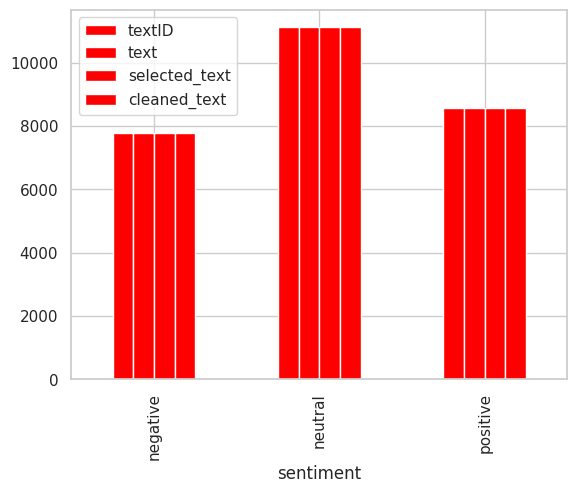

In [ ]:
# Biểu đồ giống nhau.
df.groupby('sentiment').count().plot.bar(color='red')

<Axes: xlabel='text', ylabel='Density'>

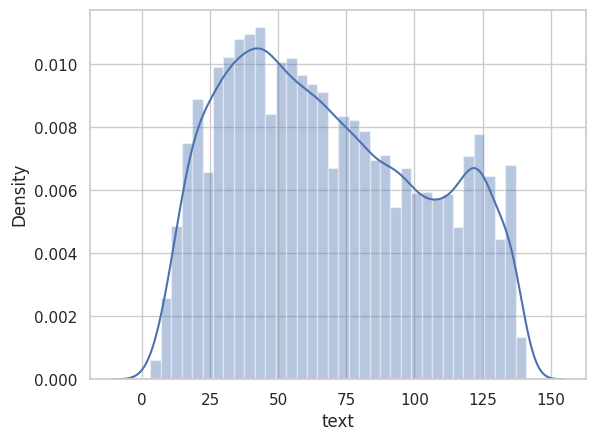

In [ ]:
sns.distplot(df.text.str.len())

In [ ]:
train_dataset = df.drop(['textID','selected_text'],axis=1)
train_dataset.head()

,text,sentiment,cleaned_text
0,"I`d have responded, if I were going",neutral,"` respond , go"
1,Sooo SAD I will miss you here in San Diego!!!,negative,sooo sad miss san diego ! ! !
2,my boss is bullying me...,negative,boss bulli ...
3,what interview! leave me alone,negative,interview ! leav alon
4,"Sons of ****, why couldn`t they put them on t...",negative,"son * * * * , ` put releas alreadi bought"


In [ ]:
# Vector hóa TF-IDF
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectors = tfidf_vectorizer.fit_transform(df['cleaned_text'])

# Word Embeddings using Word2Vec
tokenized_texts = [text.split() for text in df['cleaned_text']]
word2vec_model = gensim.models.Word2Vec(tokenized_texts, vector_size=100, window=5, min_count=1, workers=4)

In [ ]:
# Tải mô hình và mã thông báo BERT được đào tạo trước
tokenizer= BertTokenizer.from_pretrained('bert-base-uncased')
model= BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3) # 3 sentiment classes

# Mã hóa dữ liệu văn bản bằng mã thông báo
encoded_data= tokenizer.batch_encode_plus(df['text'].tolist(), max_length=128, padding=True, truncation=True, return_tensors='pt')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Chia dữ liệu thành tập huấn luyện và tập kiểm tra cho BERT
input_ids= encoded_data['input_ids']
attention_masks= encoded_data['attention_mask']
labels= torch.tensor(df['sentiment'].map({'positive': 0, 'negative': 1, 'neutral': 2}).values)

train_inputs, val_inputs, train_labels, val_labels= train_test_split(input_ids, labels, test_size= 0.2, random_state= 42)
train_masks, val_masks, _, _= train_test_split(attention_masks, input_ids, test_size= 0.2, random_state= 42)

In [ ]:
# Chuyển đổi dữ liệu của bạn sang định dạng cần thiết cho đối tượng Dataset
def convert_to_dataset(input_ids, attention_masks, labels):
    dataset = Dataset.from_dict({
        'input_ids': input_ids.numpy(),
        'attention_mask': attention_masks.numpy(),
        'labels': labels.numpy()
    })
    return dataset

In [ ]:
# Tạo tập dữ liệu huấn luyện và xác nhận
train_dataset= convert_to_dataset(train_inputs, train_masks, train_labels)
val_dataset= convert_to_dataset(val_inputs, val_masks, val_labels)

In [ ]:
# Sử dụng bộ thu thập dữ liệu để xử lý phần đệm
data_collator= DataCollatorWithPadding(tokenizer)

# Thiết lập các đối số đào tạo
training_args= TrainingArguments(output_dir='./bert_output', num_train_epochs=1, per_device_train_batch_size=16, per_device_eval_batch_size=64, warmup_steps=500, weight_decay=0.01, logging_dir='./logs', report_to= 'none')

In [ ]:
# Tạo huấn luyện viên
trainer= Trainer(model= model, args= training_args, train_dataset= train_dataset, eval_dataset= val_dataset, data_collator= data_collator, tokenizer= tokenizer)

# Huấn luyện mô hình
trainer.train()

Step,Training Loss
500,0.771700
1000,0.583600


TrainOutput(global_step=1374, training_loss=0.6354177883098219, metrics={'train_runtime': 491.2628, 'train_samples_per_second': 44.75, 'train_steps_per_second': 2.797, 'total_flos': 1242717561106560.0, 'train_loss': 0.6354177883098219, 'epoch': 1.0})

In [ ]:
# Đánh giá mô hình BERT
model.eval()
predictions= []
true_labels= []

In [ ]:
# Tạo DataLoader cho bộ xác thực
val_dataset = TensorDataset(val_inputs, val_masks, val_labels)
val_dataloader = DataLoader(val_dataset, batch_size=32)

In [ ]:
# Đưa ra dự đoán về bộ xác thực
with torch.no_grad():
    for batch in val_dataloader:
        batch = tuple(b.to(device) for b in batch)
        inputs = {'input_ids': batch[0], 'attention_mask': batch[1]}
        outputs = model(**inputs)
        logits = outputs[0]
        logits = logits.detach().cpu().numpy()
        label_ids = batch[2].to('cpu').numpy()
        predictions.extend(np.argmax(logits, axis=1))
        true_labels.extend(label_ids)

In [ ]:
# Tính toán số liệu đánh giá cho BERT
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')

print(f'BERT - Accuracy: {accuracy:.2f}')
print(f'BERT - Precision: {precision:.2f}')
print(f'BERT - Recall: {recall:.2f}')
print(f'BERT - F1 Score: {f1:.2f}')

BERT - Accuracy: 0.80
BERT - Precision: 0.80
BERT - Recall: 0.80
BERT - F1 Score: 0.80


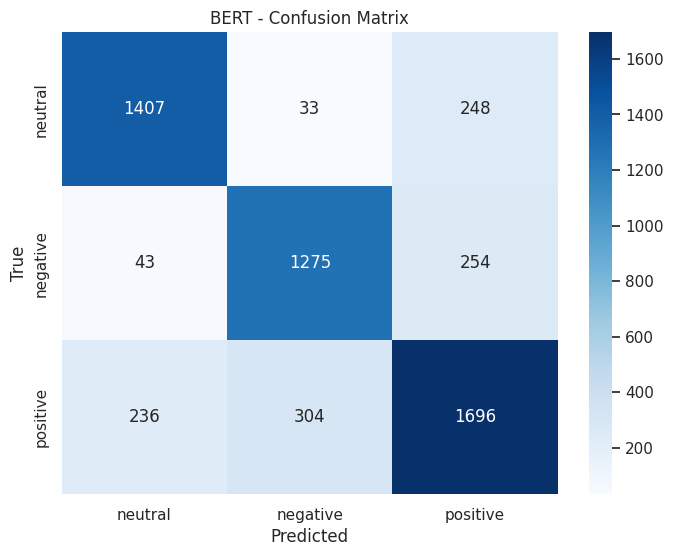

In [ ]:
# Tạo và vẽ đồ thị ma trận cho BERT
conf_matrix = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=df['sentiment'].unique(), yticklabels=df['sentiment'].unique())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('BERT - Confusion Matrix')
plt.show()

In [ ]:
# Báo cáo phân loại BERT
print("BERT - Classification Report:\n", classification_report(true_labels, predictions, target_names=df['sentiment'].unique()))

BERT - Classification Report:
               precision    recall  f1-score   support

     neutral       0.83      0.83      0.83      1688
    negative       0.79      0.81      0.80      1572
    positive       0.77      0.76      0.76      2236

    accuracy                           0.80      5496
   macro avg       0.80      0.80      0.80      5496
weighted avg       0.80      0.80      0.80      5496



In [ ]:
# Mã thông báo và tạo từ vựng
def encode_text(texts, vocab=None):
    tokenized_texts = [word_tokenize(text) for text in texts]
    if vocab is None:
        vocab = Counter([token for text in tokenized_texts for token in text])
        vocab = {word: i+1 for i, (word, count) in enumerate(vocab.items())}
    encoded_texts = [[vocab[token] for token in text if token in vocab] for text in tokenized_texts]
    return encoded_texts, vocab

encoded_texts, vocab = encode_text(df['cleaned_text'].values)

In [ ]:
# Phần đệm
def pad_sequences(sequences, maxlen):
    padded_sequences = []
    for seq in sequences:
        if len(seq) < maxlen:
            padded_sequences.append([0] * (maxlen - len(seq)) + seq)
        else:
            padded_sequences.append(seq[:maxlen])
    return np.array(padded_sequences)

maxlen = 200
X = pad_sequences(encoded_texts, maxlen=maxlen)

In [ ]:
# Nhãn mã hóa
label_encoder= LabelEncoder()
y= label_encoder.fit_transform(df['sentiment'].values)

# Tách dữ liệu
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Tạo bộ dữ liệu Tensor
train_data= TensorDataset(torch.tensor(X_train, dtype=torch.long), torch.tensor(y_train, dtype=torch.long))
val_data= TensorDataset(torch.tensor(X_val, dtype=torch.long), torch.tensor(y_val, dtype=torch.long))

# Tạo trình tải dữ liệu
batch_size= 32
train_sampler= RandomSampler(train_data)
train_dataloader= DataLoader(train_data, sampler= train_sampler, batch_size= batch_size)

val_sampler= SequentialSampler(val_data)
val_dataloader= DataLoader(val_data, sampler= val_sampler, batch_size= batch_size)

In [ ]:
# Xác định mô hình LSTM
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, drop_prob=0.5):
        super(LSTMClassifier, self).__init__()
        self.embedding= nn.Embedding(vocab_size, embedding_dim)
        self.lstm= nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout= nn.Dropout(drop_prob)
        self.fc= nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x)
        lstm_out, _= self.lstm(x)
        out= self.dropout(lstm_out[:, -1])
        out= self.fc(out)
        return out

# Siêu tham số mô hình
vocab_size= len(vocab) + 1
embedding_dim= 100
hidden_dim= 64
output_dim= 3
# Số lớp học
n_layers= 1

model= LSTMClassifier(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers)

# Siêu tham số đào tạo
epochs= 3
learning_rate= 0.001

# Mất và tối ưu hóa
criterion= nn.CrossEntropyLoss()
optimizer= optim.Adam(model.parameters(), lr=learning_rate)

# Tiêu chí dừng sớm
patience= 3
best_val_loss= np.inf
patience_counter= 0

# Di chuyển mô hình sang thiết bị
device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model= model.to(device)

In [ ]:
# Vòng lặp đào tạo với tiêu chí dừng sớm
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Tiêu chí dừng sớm
patience = 3
best_val_loss = np.inf
patience_counter = 0

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_dataloader)

    # Xác thực
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_dataloader)

    print(f'Epoch {epoch + 1}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.2f}')

    # Kiểm tra tiêu chí dừng sớm
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0  # Đặt lại bộ đếm nếu tình trạng mất xác thực được cải thiện
    else:
        patience_counter += 1  # Bộ đếm tăng nếu mất xác nhận không cải thiện

    if patience_counter >= patience:
        print(f'Early stopping at epoch {epoch + 1}')
        break  # Điểm ngắt ở trong vòng lặp

# Lưu mô hình
torch.save(model.state_dict(), 'lstm_model.pth')

Epoch 1, Training Loss: 0.9395, Validation Loss: 0.82
Epoch 2, Training Loss: 0.7448, Validation Loss: 0.79
Epoch 3, Training Loss: 0.6411, Validation Loss: 0.75


In [ ]:
model_save_path = '/content/drive/MyDrive/DoAn/Source + Data/lstm_model.pth'

In [ ]:
# Lưu mô hình vào Drive
torch.save(model.state_dict(), model_save_path)

In [ ]:
# Đánh giá mô hình
def evaluate(model, dataloader):
    model.eval()
    preds, true_labels = [], []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, pred = torch.max(outputs, 1)
            preds.extend(pred.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    return preds, true_labels

In [ ]:
# Nhận dự đoán và nhãn thực cho tập huấn luyện và xác thực
train_preds, train_labels = evaluate(model, train_dataloader)
val_preds, val_labels = evaluate(model, val_dataloader)

In [ ]:
# Tính toán số liệu đánh giá cho bộ xác thực
accuracy = accuracy_score(val_labels, val_preds)
precision = precision_score(val_labels, val_preds, average='weighted')
recall = recall_score(val_labels, val_preds, average='weighted')
f1 = f1_score(val_labels, val_preds, average='weighted')

# In số liệu đánh giá
print(f'Validation Accuracy: {accuracy:.2f}')
print(f'Validation Precision: {precision:.2f}')
print(f'Validation Recall: {recall:.2f}')
print(f'Validation F1 Score: {f1:.2f}')

Validation Accuracy: 0.68
Validation Precision: 0.69
Validation Recall: 0.68
Validation F1 Score: 0.68


In [ ]:
# Báo cáo phân loại LSTM
print("LSTM - Classification Report:\n", classification_report(val_labels, val_preds, target_names=label_encoder.classes_))

LSTM - Classification Report:
               precision    recall  f1-score   support

    negative       0.68      0.61      0.64      1572
     neutral       0.65      0.70      0.68      2236
    positive       0.73      0.74      0.73      1688

    accuracy                           0.68      5496
   macro avg       0.69      0.68      0.68      5496
weighted avg       0.69      0.68      0.68      5496

